<h2>Recognition System for Rice Leaf Diseases<h2>

In [7]:
import numpy as np
import cv2
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv

import sys
import gc
import torch

import os
import pickle
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Activation, Lambda, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Visualization and Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set GPU for faster computations

In [8]:
#Ako'y ALAPIN NG GPU KOOOOOOO
print(device_lib.list_local_devices())
phy_device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(phy_device[0],True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7983400298921651127
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2963419956
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11372750891242658603
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 850M, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


# 1. Prepare all necessary components 

## 1.1a Load Datasets with 4 classes 

In [ ]:
#Loading Pickled training and testing datasets
X_train = pickle.load(open('pickles\\X_orig_lab.pickle', 'rb'))
y_train = pickle.load(open('pickles\\y_orig_lab.pickle', 'rb'))


y_train = np.array(y_train)
X_train = X_train/255


X_testing = pickle.load(open('pickles\\X_test_orig_lab.pickle', 'rb'))
y_testing = pickle.load(open('pickles\\y_test__orig_lab.pickle', 'rb'))

y_testing = np.array(y_testing)
X_testing = X_testing/255

#Loading Pickled threshed training and testing datasets
X_train_cropped = pickle.load(open('pickles\\X_cropped_lab2_blur.pickle', 'rb'))
y_train_cropped = pickle.load(open('pickles\\y_cropped_lab2_blur.pickle', 'rb'))


y_train_cropped = np.array(y_train_cropped)
X_train_cropped = X_train_cropped/255


X_testing_cropped = pickle.load(open('pickles\\X_test_cropped_lab2_blur.pickle', 'rb'))
y_testing_cropped = pickle.load(open('pickles\\y_test_cropped_lab2_blur.pickle', 'rb'))

y_testing_cropped = np.array(y_testing_cropped)
X_testing_cropped = X_testing_cropped/255

X_train_g1 = pickle.load(open('pickles\\X_g1.pickle', 'rb'))
y_train_g1 = pickle.load(open('pickles\\y_g1.pickle', 'rb'))


y_train_g1 = np.array(y_train_g1)
X_train_g1 = X_train_g1/255


X_testing_g1 = pickle.load(open('pickles\\X_test_g1.pickle', 'rb'))
y_testing_g1 = pickle.load(open('pickles\\y_test_g1.pickle', 'rb'))

y_testing_g1 = np.array(y_testing_g1)
X_testing_g1 = X_testing_g1/255



classes = ["BrownSpot", "Healthy", "Hispa", "LeafBlast"]

print(X_train_cropped.shape)
print(y_train_cropped.shape)

print(X_testing_cropped.shape)
print(y_testing_cropped.shape)

print(X_train_g1.shape)

print(X_testing_g1.shape)

y_train[:5]

## 1.1b Loading Dataset with 3 classes (Blight, Brown spots, Leaf smut)

In [5]:
classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

In [4]:
#Loading Pickled training and testing datasets
X_train = pickle.load(open('pickles\\small_dataset\\X_train_3_classes.pickle', 'rb'))
y_train = pickle.load(open('pickles\\small_dataset\\y_train_3_classes.pickle', 'rb'))

X_train = X_train/255
y_train = np.array(y_train)


X_val = pickle.load(open('pickles\\small_dataset\\X_val_3_classes.pickle', 'rb'))
y_val = pickle.load(open('pickles\\small_dataset\\y_val_3_classes.pickle', 'rb'))

X_val = X_val/255
y_val = np.array(y_val)

X_test = pickle.load(open('pickles\\small_dataset\\X_test_3_classes.pickle', 'rb'))
y_test = pickle.load(open('pickles\\small_dataset\\y_test_3_classes.pickle', 'rb'))

X_test = X_test/255
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(2142, 224, 224, 3)
(378, 224, 224, 3)
(214, 224, 224, 3)


## 1.1c Dataset for K-fold Cross Validation

In [6]:
X_dataset = pickle.load(open('pickles\\small_dataset\\X_dataset_3_classes.pickle', 'rb'))
y_dataset = pickle.load(open('pickles\\small_dataset\\y_dataset_3_classes.pickle', 'rb'))

y_dataset = np.array(y_dataset)
# print(y_dataset[0])
# print(type(y_dataset))
# # print(y_dataset[0])
# print(type(X_dataset))
# # print(X_dataset[0])

#Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.10, shuffle = True, 
                                                    random_state = 42)
print(y_train[:5])
print(y_test[:5])


[2 1 0 0 0]
[1 1 1 2 1]


## 1.2 Visualization from pickle files

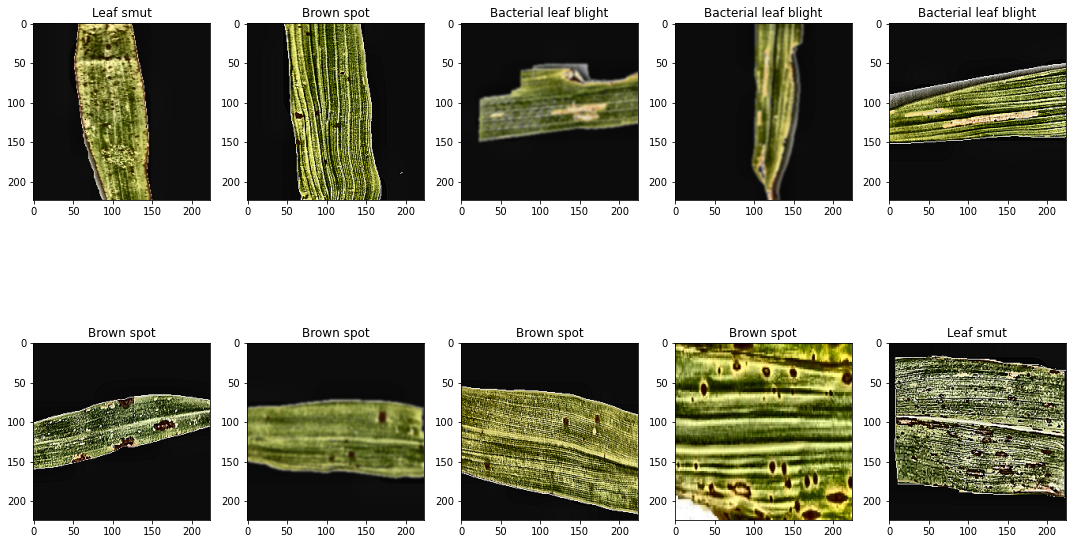

In [5]:
#Visualize images in training dataset
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Training Data
for index in range(10):   
    ax = axes[index//5, index%5]
    ax.imshow(X_train[index])
    ax.set_title(classes[y_train[index]]) 
plt.tight_layout()
plt.show()

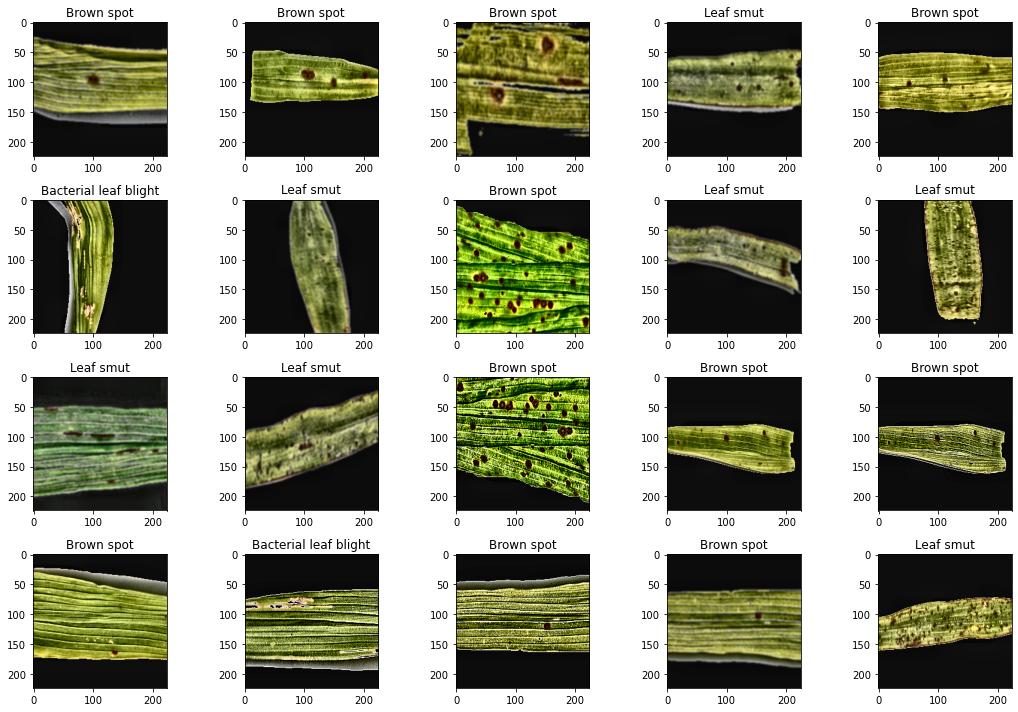

In [6]:
#Visualize images in testing dataset
fig, axes = plt.subplots(4, 5, figsize = (15,10))
#TRUE LABEL of Testing Data
for index in range(20):   
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[y_test[index]]) 
plt.tight_layout()
plt.show()

# 2. Define Visual Attention, Early Stopping, Checkpoints, and CSVLogger

In [7]:
#From https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
#By EscVM
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)
            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)
            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)

            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
    
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
            attention = self.conv2d(attention)
            
            return tf.keras.layers.multiply([inputs, attention]) 

In [8]:
# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint(f'model_checkpoints/acnn_model.h5', verbose=1, save_best_only=True)

# to save the history of models
csv_logger = CSVLogger(f'logs/acnn_model.log', separator=",", append=True)

#Kernel_regulizer to minimize overfitting/underfitting of model
regularizer = regularizers.l2(0.00020)

# 3. CNN Models

## 3.1 CNN Model with no Visual Attention

#### 3.1.1 Training CNN Model

In [10]:
#AlexNet CNN Model with no visual attention
def build_model_no_attention():
    
    acnn_model = Sequential()
    optimizer = tf.keras.optimizers.Adam(0.0000088)
    
    acnn_model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = 'same', activation = 'relu',
                      input_shape = (224,224,3), data_format = 'channels_last'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))


    acnn_model.add(Conv2D(filters = 256, kernel_size = (5,5), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))

    acnn_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2) ))

    acnn_model.add(Flatten())
    acnn_model.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model.add(Dropout(0.5))

    acnn_model.add(Dense(100, activation ='relu',kernel_regularizer= regularizer))
    acnn_model.add(Dropout(0.5))

    acnn_model.add(Dense(3, activation = 'softmax'))

    
    acnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])

    return acnn_model


In [11]:
#Define AlexNet model and Train
acnn_model = build_model_no_attention()
acnn_hist = acnn_model.fit(X_train, y_train, verbose = 1, batch_size = 32,validation_split = 0.1111111111,
                   epochs=50, callbacks = [early_stopping, model_checkpoint, csv_logger])

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 2.0860 - accuracy: 0.3433
Epoch 1: val_loss improved from inf to 1.14908, saving model to model_checkpoints\acnn_model.h5
63/63 [==============================] - 27s 318ms/step - loss: 2.0860 - accuracy: 0.3433 - val_loss: 1.1491 - val_accuracy: 0.3452
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 1.3483 - accuracy: 0.4137
Epoch 2: val_loss improved from 1.14908 to 1.09312, saving model to model_checkpoints\acnn_model.h5
63/63 [==============================] - 15s 230ms/step - loss: 1.3483 - accuracy: 0.4137 - val_loss: 1.0931 - val_accuracy: 0.4643
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.4519
Epoch 3: val_loss improved from 1.09312 to 1.04950, saving model to model_checkpoints\acnn_model.h5
63/63 [==============================] - 14s 230ms/step - loss: 1.1790 - accuracy: 0.4519 - val_loss: 1.0495 - val_accuracy: 0.5317
Epoch 4/50
63/63 [========

63/63 [==============================] - 14s 225ms/step - loss: 0.5231 - accuracy: 0.8065 - val_loss: 0.5685 - val_accuracy: 0.8095
Epoch 27/50
63/63 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.8125
Epoch 27: val_loss improved from 0.55864 to 0.52545, saving model to model_checkpoints\acnn_model.h5
63/63 [==============================] - 15s 231ms/step - loss: 0.4974 - accuracy: 0.8125 - val_loss: 0.5254 - val_accuracy: 0.8452
Epoch 28/50
63/63 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8313
Epoch 28: val_loss improved from 0.52545 to 0.50865, saving model to model_checkpoints\acnn_model.h5
63/63 [==============================] - 15s 231ms/step - loss: 0.4729 - accuracy: 0.8313 - val_loss: 0.5087 - val_accuracy: 0.8413
Epoch 29/50
63/63 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.8398
Epoch 29: val_loss did not improve from 0.50865
63/63 [==============================] - 14s 226ms/step - loss: 0.465

#### 3.1.2 Visualization of Train-Validation Accuracy and Loss 

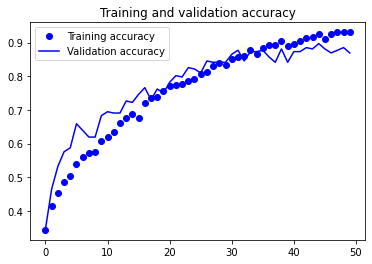

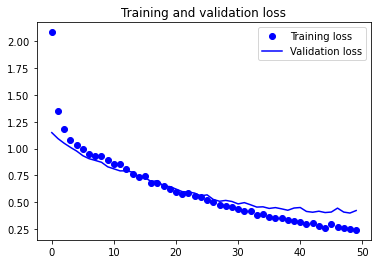

In [12]:
#Visualization of Train-Validation Accuracy and Loss
accuracy = acnn_hist.history['accuracy']
val_accuracy = acnn_hist.history['val_accuracy']
loss = acnn_hist.history['loss']
val_loss = acnn_hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 3.1.3 Model Evaluation on Testing Dataset and Summary of Model's structure

In [13]:
acnn_model.evaluate(X_test,y_test)

8/8 [==============================] - 1s 71ms/step - loss: 0.3199 - accuracy: 0.9008


[0.31990933418273926, 0.9007936716079712]

In [14]:
acnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

## 3.2 CNN Model with Attention

#### 3.2.1 Training CNN Model

In [9]:
#AlexNet CNN Model with visual attention
def build_model_with_attention():
    acnn_model_wa = Sequential()
    
    optimizer = tf.keras.optimizers.Adam(0.0000088)
    
    acnn_model_wa.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = 'same', activation = 'relu',
                      input_shape = (224,224,3), data_format = 'channels_last'))

    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(96,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))


    acnn_model_wa.add(Conv2D(filters = 256, kernel_size = (5,5), strides=(1,1), padding='same', activation = 'relu'))

    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(256,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))

    acnn_model_wa.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(384,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(384,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(Conv2D(filters = 256, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(256,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size = (3,3), strides = (2,2) ))

    acnn_model_wa.add(Flatten())
    acnn_model_wa.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model_wa.add(Dropout(0.5))

    acnn_model_wa.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model_wa.add(Dropout(0.5))

    acnn_model_wa.add(Dense(3, activation = 'softmax'))

    
    acnn_model_wa.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])

    return acnn_model_wa


In [10]:
acnn_model_wa = build_model_with_attention()
acnn_wa_hist = acnn_model_wa.fit(X_train, y_train, verbose = 1, batch_size = 32,validation_split = 0.1111111111,
                   epochs=50, callbacks = [early_stopping, csv_logger])
    

Epoch 1/50
63/63 [==============================] - 25s 319ms/step - loss: 2.0047 - accuracy: 0.3566 - val_loss: 1.1629 - val_accuracy: 0.3611
Epoch 2/50
63/63 [==============================] - 15s 239ms/step - loss: 1.2748 - accuracy: 0.4077 - val_loss: 1.1064 - val_accuracy: 0.4722
Epoch 3/50
63/63 [==============================] - 15s 234ms/step - loss: 1.1584 - accuracy: 0.4246 - val_loss: 1.0703 - val_accuracy: 0.5675
Epoch 4/50
63/63 [==============================] - 15s 234ms/step - loss: 1.0989 - accuracy: 0.4499 - val_loss: 1.0489 - val_accuracy: 0.5754
Epoch 5/50
63/63 [==============================] - 15s 234ms/step - loss: 1.0598 - accuracy: 0.4861 - val_loss: 1.0199 - val_accuracy: 0.5675
Epoch 6/50
63/63 [==============================] - 15s 235ms/step - loss: 1.0168 - accuracy: 0.5258 - val_loss: 0.9944 - val_accuracy: 0.5873
Epoch 7/50
63/63 [==============================] - 15s 234ms/step - loss: 1.0163 - accuracy: 0.5228 - val_loss: 0.9677 - val_accuracy: 0.6270

#### 3.2.2 Visualization of Train-Validation Accuracy and Loss 

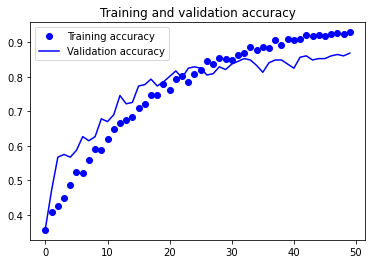

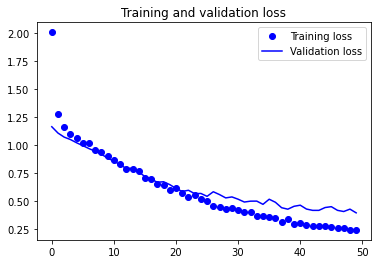

In [11]:
#Visualization of Train-Validation Accuracy and Loss
accuracy = acnn_wa_hist.history['accuracy']
val_accuracy = acnn_wa_hist.history['val_accuracy']
loss = acnn_wa_hist.history['loss']
val_loss = acnn_wa_hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 3.2.3 Model Evaluation on Testing Dataset and Summary of Model's structure

In [12]:
acnn_model_wa.evaluate(X_test,y_test)

8/8 [==============================] - 1s 83ms/step - loss: 0.3305 - accuracy: 0.9087


[0.3305462598800659, 0.908730149269104]

In [13]:
acnn_model_wa.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 channel_attention (ChannelA  (None, 56, 56, 96)       0         
 ttention)                                                       
                                                                 
 spatial_attention (SpatialA  (None, 56, 56, 96)       0         
 ttention)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                      

# 4. K-Fold Cross Validation

### 4.1 Evaluation of Models using K-Fold

#### 4.1.1 CNN Model with no Visual Attention

In [ ]:
#Change the no. of epochs
seed = 10
np.random.seed(seed)

skf = StratifiedKFold(n_splits=10, random_state= seed, shuffle = True)
cvscores = []
# X_dataset is the feature set and y_dataset is the target
for train_index, test_index in skf.split(X_dataset,y_dataset):
    acnn_model = build_model_no_attention()
    acnn_hist = acnn_model.fit(X_dataset[train_index], y_dataset[train_index], verbose = 1, batch_size = 16,
                               validation_split = 0.1111111111, epochs=5)
    scores = acnn_model.evaluate(X_dataset[test_index], y_dataset[test_index])
    print("%s: %.2f%%" % (acnn_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)


#### 4.1.1.1 Overall Performance of CNN model without Visual Attention

In [ ]:
print("%.2f%% (+/-%.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

#### 4.1.2 CNN Model with Visual Attention

In [ ]:
#Change the no. of epochs
skf = StratifiedKFold(n_splits=10, random_state= seed, shuffle = True)
cvscores = []
# X_dataset is the feature set and y_dataset is the target
for train_index, test_index in skf.split(X_dataset,y_dataset):
    acnn_model_wa = build_model_with_attention()
    acnn_wa_hist = acnn_model_wa.fit(X_dataset[train_index], y_dataset[train_index], 
                                     verbose = 1, batch_size = 16,validation_split = 0.1111111111, epochs=5)
    scores = acnn_model_wa.evaluate(X_dataset[test_index], y_dataset[test_index])
    print("%s: %.2f%%" % (acnn_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)


#### 4.1.2.1 Overall Performance of CNN model with Visual Attention

In [ ]:
print("%.2f%% (+/-%.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

### 4.2 Visualization from split of K-Fold

In [ ]:
#Visualize images in training dataset
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Training Data
for index in range(10):   
    ax = axes[index//5, index%5]
    ax.imshow(X_train[index])
    ax.set_title(classes[y_train[index]]) 
plt.tight_layout()
plt.show()

# 5. Comparison of CNN model w/ and w/o Attention

### 5.1 Loading and Predicting Testing dataset using the 2 Models

In [ ]:
saved_model = tf.keras.models.load_model('model_checkpoints/acnn_model_no_attention_50_v1.1.h5')

In [ ]:
saved_model.evaluate(X_test, y_test)

In [ ]:
no_attention_pred = saved_model.predict(X_test)

with_attention_pred = acnn_model_wa.predict(X_test)
print(no_attention_pred[:5])
print(with_attention_pred[:5])

In [ ]:
#PREDICTED LABEL
na_pred_labels = np.argmax(no_attention_pred, axis = 1)
wa_pred_labels = np.argmax(with_attention_pred, axis = 1)
print("Actual Labels")
print(y_test[:5])
print("===================")
print("No Attention Predicted Labels")
print(na_pred_labels[1:])
print("===================")
print("With Attention Predicted Labels")
print(wa_pred_labels[1:])

### 5.2 Visualization of TRUE and PREDICTED Labels

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Testing DATASET
for index in range(15):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[y_test[index]]) 
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#PREDICTED LABEL of ACNN model with no attention
for index in range(10):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[na_pred_labels[index]]) 
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 5, figsize = (15,10))
#PREDICTED LABEL of ACNN model with attention
for index in range(15):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[wa_pred_labels[index]]) 
plt.tight_layout()
plt.show()